# Part 1 Sequence Tagging: NER


## Q1.1 Word Embedding

### Q1.1.1 Download Dependency

In [9]:
!pip install --upgrade gensim

  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/ab/b0/d58dc405fd60ab546ca714321235dc2d455b2dc06bfb4fc1092940c749fc/gensim-4.3.2-cp310-cp310-win_amd64.whl.metadata
  Using cached gensim-4.3.2-cp310-cp310-win_amd64.whl.metadata (8.5 kB)
Using cached gensim-4.3.2-cp310-cp310-win_amd64.whl (24.0 MB)
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.0
    Uninstalling gensim-4.3.0:
      Successfully uninstalled gensim-4.3.0


### Q1.1.2 Download the pretrained word2vec embeddings 

In [1]:
import gensim.downloader
import numpy as np
import pandas as pd
import csv
import random
from sklearn.metrics.pairwise import cosine_similarity

#Download the embeddings "word2vec-google-news-300"
w2v = gensim.downloader.load('word2vec-google-news-300')

---
### Question 1.1
###### Based on word2vec embeddings you have downloaded, use cosine similarity to find the most similar word to each of these words: (a) “student”; (b) “Apple”; (c) “apple”. Report the most similar word and its cosine similarity.

In [2]:
def get_word_and_cosine_similarity(word:list, top_n:int):
    result = {}
    for w in word:
        similarities = w2v.cosine_similarities(w2v[w], w2v.vectors)
        sorted_similarities = sorted(similarities[:], reverse=True)[:top_n+1]
        result[w] = [(w2v.index_to_key[np.where(similarities == s)[0][0]], s) for s in sorted_similarities if w2v.index_to_key[np.where(similarities == s)[0][0]]!=w]
    return result

In [3]:
word_list = ["student", "Apple", "apple"]
print("Most similar word and its cosine similarity by using .most_similar(): ")
for word in word_list:
    print(word+'\t', w2v.most_similar(word,topn=1))

print("\nMost similar word and its cosine similarity by using .cosine_similarities(): ")
r = get_word_and_cosine_similarity(word_list, 1)
for k,v in r.items():
    print(k+'\t', v)

Most similar word and its cosine similarity by using .most_similar(): 
student	 [('students', 0.7294867038726807)]
Apple	 [('Apple_AAPL', 0.7456986308097839)]
apple	 [('apples', 0.720359742641449)]

Most similar word and its cosine similarity by using .cosine_similarities(): 
student	 [('students', 0.7294867)]
Apple	 [('Apple_AAPL', 0.74569863)]
apple	 [('apples', 0.72035974)]


---
### 1.2 Data
###### Then you can start to prepare the dataset. For NER, you will work with [CoNLL2003](https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/tree/master/data) (click and download “eng.testa”, “eng.testb”, “eng.train”). Before training, you need to preprocess the dataset such that each of them contains a training file, a development file and a test file. The development file is used to select the best model during training. The test file is used for final evaluation. For CoNLL2003, the training, development and test file corresponds to “eng.train”, “eng.testa” and “eng.testb”, respectively. Note that you only need to use the first and the last column of each line corresponding to the input word and the word label, respectively. A screenshot of the data is shown in Figure 1. In this example, there are two sentences (separated by ‘\n’). The input for each sentence is composed of the words from the first column. For example, the first sentence in Figure 1 corresponds to “CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY.” The label for each of the first 3 words CRICKET, -, LERCESTERSHIRE corresponds to ‘O’, ‘O’, ‘I-ORG’, respectively

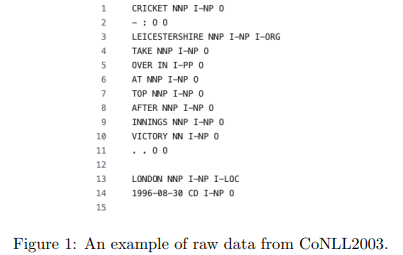

In [2]:
# Define the file paths
train_file = "eng.train"
verification_file = "eng.testa"
test_file = "eng.testb"

# Function to read and process a CoNLL2003 file and returns df
def process_files(file_path, csv_name):
    """ Parameters:
        - file_path: CoNLL2003 files
        - csv_name: Bool
             returns pd file, columns: ["Sentence Number", "Word", "NEr tag"]
    """
    data = []
    sentence_no = 1
    with open(file_path, 'r', encoding='utf-8') as file:
        for row in file:
            line = row.strip()
            if not line:  # Empty line indicates end of a sentence
                sentence_no += 1
            else:
                ner = line.split(" ")
                # ensuring that for each data there is a word and the word's NER label
                assert all([ner[i] for i in range(4)])
                data.append([sentence_no, ner[0], ner[3]])
    
    with open(csv_name, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Sentence Number", "Word", "NEr tag"])
        for word in data:
            writer.writerow([word[0], word[1], word[2]])
    return pd.read_csv(csv_name)

# Function to load existing csv file if have
def load_files(file_name):
    return pd.read_csv(file_name)

# Process the data files
train_df = process_files(train_file, csv_name="train_data.csv")
validation_df = process_files(verification_file, csv_name="verification_data.csv")
test_df = process_files(test_file, csv_name="test_data.csv")

### Question 1.2
###### (a) Describe the size (number of sentences) of the training, development and test file for CoNLL2003. Specify the complete set of all possible word labels based on the tagging scheme (IO, BIO, etc.) you chose.

In [5]:
file_labels = ["Training", "Verification", "Test"]
for i, df in enumerate([train_df, validation_df, test_df]):
    print("="*100)
    print(f"{file_labels[i]} data information")
    print(f"> Number of sentences:    {df['Sentence Number'].max()}")
    print(f"> Count of Unique words:  {len(df['Word'].unique())}")
    print(f"> Type of tags:           {sorted(df['NEr tag'].unique())}\n")
print("="*100,'\n')

print("With the given shapes, parameters and type of tags exists, we select the tagging scheme to be BIO as it has B,I,O tags.")

Training data information
> Number of sentences:    14987
> Count of Unique words:  23623
> Type of tags:           ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Verification data information
> Number of sentences:    3466
> Count of Unique words:  9966
> Type of tags:           ['B-MISC', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Test data information
> Number of sentences:    3684
> Count of Unique words:  9489
> Type of tags:           ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


With the given shapes, parameters and type of tags exists, we select the tagging scheme to be BIO as it has B,I,O tags.


###### (b) Choose an example sentence from the training set of CoNLL2003 that has at least two named entities with more than one word. Explain how to form complete named entities from the label for each word, and list all the named entities in this sentence.

In [6]:
def get_q1_2_b(dataset, min_sentence_len=10, random_seed=1):
    s,w,t = np.inf,[],[]
    sentences = {}
    tags = {}
    for index, row in dataset.iterrows():
        if s!=row["Sentence Number"]: # new sentence detected
            sentences[s] = w
            tags[s] = t
            s,w,t = row["Sentence Number"], [], []
        w.append(row["Word"])
        t.append(row["NEr tag"])
    
    x = [i for i in range(len(sentences))]
    random.Random(random_seed).shuffle(x)
    for idx in x:
    # Check existing for at least two consequtive named entities with more than one word using sliding window
        if len(sentences[idx]) >= min_sentence_len:
            for i in range(1, len(tags[idx])):
                if tags[idx][i-1]!='O' and tags[idx][i]!='O': # Check if both is not 'O' tag
                    if tags[idx][i-1].split("-")[1] == tags[idx][i].split("-")[1]: # Check if both NE tags are the same type e.g. LOC/MISC/ORG/PER
                        return idx, sentences[idx], tags[idx]
    return None, None

def get_ne(sentence, tag):
    phrases = {}
    temp_phrase = []
    first_tag = ''
    for i in range(1, len(sentence)):
        if tag[i] != 'O':
            if not first_tag: 
                first_tag = tag[i].split('-')[1]
            if first_tag == tag[i].split('-')[1]: 
                temp_phrase.append(sentence[i])
        else:
            if temp_phrase:
                phrases[' '.join(temp_phrase)] = first_tag
                temp_phrase = []
            else:
                temp_phrase = []
                first_tag = ''
    return phrases

sentence_no, sentence, tags = get_q1_2_b(train_df, min_sentence_len=10, random_seed=1)
name_entities = get_ne(sentence, tags)

In [7]:
print(f"Original sentence:\n> {' '.join(sentence)}\n")
print(f"Original tag:\n> {' '.join(tags)}\n")
print(f"Tagged sentence selected:\n> {' '.join([sentence[i]+'/'+ tags[i] for i in range(len(sentence))])}\n")

print("Name entities found: ")
for k,v in name_entities.items():
    print(f"> {v}: {k}")

print('\nTo form complete named entities from the label for each word, we need to consider firstly that the tags are provided/able to be retrieved by corpus/gazetteer. For each single/consequtive Name Entities(ER) recognition tags, it is the complete phrase of the name entity. The type of the entity can be known by the tag itself, if in this example, ORG was tagged and hence we know the word/phrase is an Organization. However, the data provided does not fully follow the BIO tagging scheme entirely, with the start of the NE phrase not tagged with a "B", and since when we are using the "BIO" tagging scheme there is no Stop/Ending tags, hence the only way we can segregate phrases is by using the "O"-outside "BIO" tag. ')

Original sentence:
> Outright gas oil prices were notionally softer as the NYMEX heating oil contract headed lower , and following news that the Indian Oil Corp ( IOC ) had issued a tender to buy only 120,000 tonnes of high speed diesel for October .

Original tag:
> O O O O O O O O O O O O O O O O O O O O O I-ORG I-ORG I-ORG O I-ORG O O O O O O O O O O O O O O O O O

Tagged sentence selected:
> Outright/O gas/O oil/O prices/O were/O notionally/O softer/O as/O the/O NYMEX/O heating/O oil/O contract/O headed/O lower/O ,/O and/O following/O news/O that/O the/O Indian/I-ORG Oil/I-ORG Corp/I-ORG (/O IOC/I-ORG )/O had/O issued/O a/O tender/O to/O buy/O only/O 120,000/O tonnes/O of/O high/O speed/O diesel/O for/O October/O ./O

Name entities found: 
> ORG: Indian Oil Corp
> ORG: IOC

To form complete named entities from the label for each word, we need to consider firstly that the tags are provided/able to be retrieved by corpus/gazetteer. For each single/consequtive Name Entities(ER) recogn

---
### 1.3 Model
###### Now with the pretrained word embeddings acquired from Section 1.1, and the CoNLL2003 dataset acquired from Section 1.2, you need to train an NER model using the training set, conforming to these requirements:
• Use the pretrained word embeddings from Section 1.1 as inputs; do not update them during training (they are “frozen”).

• Design a neural network transforming the input for each word to its final vector representation, which will be fed into the softmax classifier to predict the final label for each word. The neural network could be a simple linear layer, a feedforward network (a linear transformation plus a nonlinear activation function), or a recurrent neural network (RNN/LSTM). You are encouraged to use more effective networks (e.g., LSTM) because the performance of the model will be taken into consideration when graded.

• Use the development set to evaluate the performance of the model for each epoch during training. Please use f1 score to measure the performance. For evaluation metric and code, refer to the following link: https://github.com/chakki-works/seqeval/tree/master. (Please make sure your sequence tagging scheme aligns with the provided evaluation code. Otherwise,
you may revise the code accordingly.)

• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g., SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and mini-batch size. (You may use the development set to check the performance and decide the optimal configuration.) Train the network until the f1 score on the development set is not increasing. Use the trained network to classify words in the test set.

#### Question 1.3
###### (a) Discuss how you deal with new words in the training set which are not found in the pretrained dictionary. Likewise, how do you deal with new words in the test set which are not found in either the pretrained dictionary or the training set? Show the corresponding code snippet.

In [105]:
# Function to preprocess the data and convert NER tags to numerical labels
def preprocess_data(df, w2v_model, label):
    word_embeddings = []
    ner_labels = []
    for i, row in df.iterrows():
        word = row['Word']
        ner_tag = row['NEr tag']
        if word in w2v_model:
            word_vector = w2v_model[word]
        else:
#             word_vector = np.zeros(300)  # Use zero vectors for out-of-vocabulary words
            word_vector = np.zeros((300,))
        assert len(word_vector) == 300
        word_embeddings.append(word_vector)
        onehot = [0]*len(label)
        onehot[label.index(ner_tag)] = 1
        ner_labels.append(onehot)
    return torch.tensor(np.array(word_embeddings), dtype=torch.float64), torch.tensor(np.array(ner_labels), dtype=torch.long)

class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [129]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings):
        super(NERModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)  # Freeze the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2 * hidden_dim, num_labels)  # Multiply by 2 for bidirectional LSTM
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):    
        x = torch.clamp(x, min=0, max=self.embedding.num_embeddings - 1)
        x = x.long()
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        logits = self.linear(lstm_out)
        output = self.softmax(logits)
        
        return output

# Define hyperparameters
ner_labels = ['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'I-PER', 'O']
embedding_dim = 300
hidden_dim = 128 # Change to see if there are any improvements
num_labels = len(ner_labels)
pretrained_embeddings = torch.FloatTensor(w2v.vectors) 

# Initialize the NER model
model = NERModel(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
# # not updating the weights during training
# model.embedding.weight.requires_grad = False
# Define your loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [130]:
from torch.utils.data import DataLoader, TensorDataset

X_train, y_train = preprocess_data(train_df, w2v, ner_labels)
train_dataset = TensorDataset(X_train, y_train)
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

X_validation, y_validation = preprocess_data(validation_df, w2v, ner_labels)
validation_dataset = TensorDataset(X_validation, y_validation)
validation_data_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

In [ ]:
import tqdm
# Initialize EarlyStopper
early_stopper = EarlyStopper(patience=3)

# Lists to store train and test accuracies and losses
train_accuracies = []
validation_accuracies = []
train_losses = []
validation_losses = []

# Training loop
epochs = 10

for epoch in tqdm.tqdm(range(epochs)):
#=======================Training=======================
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for idx, batch in enumerate(train_data_loader):
        batch_data, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = loss_fn(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Calculate train accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += batch_labels.size(0)
        correct_train += (predicted == batch_labels).sum().item()
    
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)  # Store train loss
    
#=======================Testing=======================
    model.eval()
    val_loss = 0.0
    correct_validation = 0
    total_validation = 0
    with torch.no_grad():
        for batch_data, batch_labels in validation_data_loader:
            outputs = model(batch_data)
            loss = loss_fn(outputs, batch_labels)
            val_loss += loss.item()
            
            # Calculate test accuracy
            _, predicted = torch.max(outputs, 1)
            total_validation += batch_labels.size(0)
            correct_validation += (predicted == batch_labels).sum().item()
    
    test_accuracy = correct_validation / total_validation
    validation_accuracies.append(test_accuracy)
    validation_losses.append(val_loss)  # Store test loss
    
    avg_train_loss = train_loss / len(train_data_loader)
    avg_val_loss = val_loss / len(validation_data_loader)
    
    # Check for early stopping
    if early_stopper.early_stop(avg_val_loss):
        print(f"Early stopping at epoch ({epoch+1}) due to no improvement in validation loss.")
        break
    
    # Print epoch results
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

 10%|███████▉                                                                       | 1/10 [21:55<3:17:15, 1315.07s/it]

Epoch 1/10, Train Loss: 5.6016, Val Loss: 5.5999, Train Accuracy: 6.8121, Test Accuracy: 6.8332


 20%|███████████████▊                                                               | 2/10 [44:02<2:56:18, 1322.37s/it]

Epoch 2/10, Train Loss: 5.5998, Val Loss: 5.5999, Train Accuracy: 6.8336, Test Accuracy: 6.8332


 30%|███████████████████████                                                      | 3/10 [1:06:08<2:34:26, 1323.79s/it]

Epoch 3/10, Train Loss: 5.5998, Val Loss: 5.5999, Train Accuracy: 6.8336, Test Accuracy: 6.8332


 40%|██████████████████████████████▊                                              | 4/10 [1:28:24<2:12:53, 1328.97s/it]

Epoch 4/10, Train Loss: 5.5998, Val Loss: 5.5999, Train Accuracy: 6.8336, Test Accuracy: 6.8332


### Old codes

In [ ]:
# Initialize the EarlyStopper
early_stopper = EarlyStopper(patience=3)

# Training and validation loop
epochs = 10
for epoch in tqdm.tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    for batch_data, batch_labels in train_data_loader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = loss_fn(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_data_loader)
    print(f"Epoch [{epoch + 1}/{epochs}] - Training Loss: {average_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_data, batch_labels in val_data_loader:
            outputs = model(batch_data)
            loss = loss_fn(outputs.view(-1, num_labels), batch_labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.view(-1, num_labels), 1)
            total_val += batch_labels.size(0)
            correct_val += (predicted == batch_labels).sum().item()
    val_accuracy = correct_val / total_val
    average_val_loss = val_loss / len(val_data_loader)
    print(f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Implement early stopping
    if early_stopper.early_stop(average_val_loss):
        print("Early stopping triggered. No improvement in validation loss.")
        break  # Exit the training loop

In [108]:
outputs.shape, batch_labels.shape

(torch.Size([32, 300, 8]), torch.Size([32]))

In [90]:
outputs.shape

torch.Size([32, 300, 8])

In [ ]:
# Define NER labels mapping


# Convert NER tags to numerical labels
train_df['NER Label'] = train_df['NEr tag'].map(ner_labels)
validation_df['NER Label'] = validation_df['NEr tag'].map(ner_labels)

# Tokenize and preprocess the data
X_train, y_train = preprocess_data(train_df, w2v)
X_validation, y_validation = preprocess_data(validation_df, w2v)

# Define the NER model
model = Sequential()
model.add(Embedding(input_dim=X_train.shape[0], output_dim=300, input_length=X_train.shape[1], weights=[X_train], trainable=False))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dense(8, activation='softmax'))  # 8 output classes (NER labels)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10)

In [ ]:
# Evaluate performance using F1 score
y_pred = model.predict(X_validation)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_validation, axis=-1)
f1 = f1_score(y_true, y_pred)
print(f"F1 Score on Validation Set: {f1}")

# Predict on the test set
y_test_pred = model.predict(X_test)

In [355]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Ensure date format datas etc are all in string parameters
def list_of_words(df):
    return [str(word) for word in df['Word'].to_list()]

def create_embedding_matrix(word2vec_model, word_index):
    embedding_dim = word2vec_model.vector_size
    vocab_size = len(word_index) + 1  # Adding 1 to account for the reserved index 0

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]

    return embedding_matrix

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list_of_words(train_df))
word_index = tokenizer.word_index

# Vocabulary size
vocab_size = len(word_index) + 1
tag_types = train_df['NEr tag'].unique()

# Create sequences for training, validation, and test data
max_sequence_length = 100  # You can adjust this based on your data

X_train = pad_sequences(tokenizer.texts_to_sequences(list_of_words(train_df)), maxlen=max_sequence_length)
X_val = pad_sequences(tokenizer.texts_to_sequences(list_of_words(validation_df)), maxlen=max_sequence_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(list_of_words(test_df)), maxlen=max_sequence_length)

embedding_dim = 300  # Word2Vec embedding dimension

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, trainable=False, weights=[create_embedding_matrix(w2v, word_index)]))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(len(tag_types), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [425]:
import tqdm

def sentence_integrate(data):
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                 s["NEr tag"].values.tolist())]
    return data.groupby('Sentence Number').apply(agg_func).tolist()
  
train_df_sentences = sentence_integrate(train_df)
validation_df_sentences = sentence_integrate(validation_df)

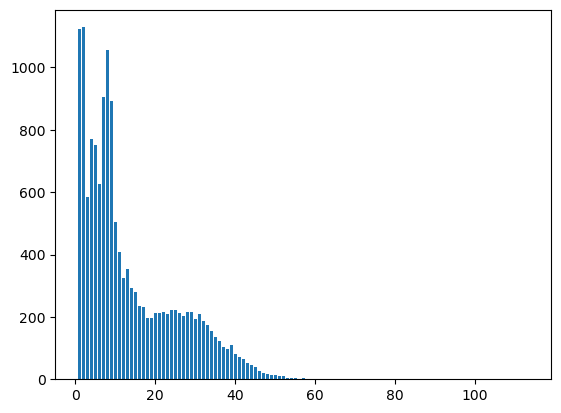

In [426]:
from collections import defaultdict
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

count_of_sentence_lengths = defaultdict(int)
for s in train_df_sentences:
    count_of_sentence_lengths[len(s)]+=1

plt.bar(count_of_sentence_lengths.keys(), count_of_sentence_lengths.values())
plt.show()

In [430]:
    def get_mode_selection(df, sentences):
        X = df["Word"].tolist()
        y = df["NEr tag"].tolist()
        
        words = list(set(df["Word"].values))
        # words.append("ENDPAD")
        num_words = len(words)

        tags = list(set(df["NEr tag"].values))
        num_tags = len(tags)

        word2idx = {w: i for i, w in enumerate(X)}
        tag2idx = {t: i for i, t in enumerate(y)}

        X = [[word2idx[w[0]] for w in s] for s in sentences]
        X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words)

        y = [[tag2idx[w[1]] for w in s] for s in sentences]
        y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
        
        return X, y

In [431]:
X_train, y_train = get_mode_selection(train_df, train_df_sentences)
X_validation, y_validation = get_mode_selection(validation_df, validation_df_sentences)

In [439]:
#split into test and train
from sklearn.model_selection import train_test_split

#build model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras

max_len = 50
words = list(set(train_df["Word"].values))
num_words = len(words)

model = keras.Sequential()
model.add(InputLayer((max_len)))
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

#model summary
model.summary()

#compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 50)            1181150   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 200)          120800    
 nal)                                                            
                                                                 
Total params: 1,301,950
Trainable params: 1,301,950
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define your model architecture
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_seq_length, weights=[embedding_matrix], trainable=False))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_dev, y_dev), batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])


In [446]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]


history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_validation, y_validation),
    batch_size=32, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
    
)

#Apply TensorBoard to check the detailed structure and performance
%load_ext tensorboard

%tensorboard --logdir log

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_7/embedding_5/embedding_lookup' defined at (most recent call last):
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\asyncio\base_events.py", line 1909, in _run_once
      sys.set_coroutine_origin_tracking_depth(
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\woony\AppData\Local\Temp\ipykernel_26516\1706387013.py", line 6, in <module>
      history = model.fit(
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_7/embedding_5/embedding_lookup'
indices[16,0] = 140952 is not in [0, 23623)
	 [[{{node sequential_7/embedding_5/embedding_lookup}}]] [Op:__inference_train_function_21037]

In [366]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          5304300   
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          219648    
                                                                 
 dense (Dense)               (None, 100, 8)            1032      
                                                                 
Total params: 5,524,980
Trainable params: 220,680
Non-trainable params: 5,304,300
_________________________________________________________________


In [363]:
# Define a mapping from your tag types to integer labels
tag_to_label = {tag: idx for idx, tag in enumerate(tag_types)}

# Convert tags to integer labels
y_train = [tag_to_label[tag] for tag in train_df['NEr tag']]
y_val = [tag_to_label[tag] for tag in validation_df['NEr tag']]
y_test = [tag_to_label[tag] for tag in test_df['NEr tag']]

# Convert integer labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(tag_types))
y_val = to_categorical(y_val, num_classes=len(tag_types))
y_test = to_categorical(y_test, num_classes=len(tag_types))

# Define the number of classes
num_classes = len(tag_types)

# Convert integer labels to one-hot encoding for each word in the sequence
y_train_onehot = [to_categorical(y, num_classes=num_classes) for y in y_train]
y_val_onehot = [to_categorical(y, num_classes=num_classes) for y in y_val]

# Convert the lists to numpy arrays
y_train_onehot = np.array(y_train_onehot)
y_val_onehot = np.array(y_val_onehot)

In [364]:
model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot), epochs=5, batch_size=64)

Epoch 1/5


ValueError: in user code:

    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 8, 8) and (None, 100, 8) are incompatible


In [358]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

Epoch 1/5


ValueError: in user code:

    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\woony\anaconda3\envs\cz4045_env\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 8) and (None, 100, 8) are incompatible
